In [1]:
'''
Editor: @Hyunhomo
Source: https://github.com/mohyunho/abnormal_temperature_prediction

Load merged&labeled features and train machine learning model
'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from datetime import datetime
from sklearn.ensemble import GradientBoostingClassifier

## Load features from csv files
labeled_temp_feat = pd.read_csv('labeled_temp_feat.csv')
labeled_temp_feat['date'] = pd.to_datetime(labeled_temp_feat['date'], format="%Y-%m-%d %H:%M:%S")



## Function to derive current time with the format of pandas timestamp '%Y-%m-%d %H:%M:00' 
def current_time():
    ct = datetime.now()
    ct_minute = ct.strftime('%Y-%m-%d %H:00:00')
#     ct_ts = pd.to_datetime(ct_minute)
    ct_ts = pd.Timestamp(ct_minute, freq='t')
    return ct_ts

## Generate a fixed frequency DatetimeIndex
# Set current time(minute) as the threshold for training/test dataset split 
current_minute = current_time()

print ("labeled_temp_feat['date'][0]", labeled_temp_feat['date'][0] )

threshold_dates = [[labeled_temp_feat['date'][0],current_minute ],
                   [current_minute, labeled_temp_feat['date'].iloc[-1]]]

for last_train_date, first_test_date in threshold_dates:
    print ("last_train_date", last_train_date)
    print("first_test_date", first_test_date)


print ("current_minute", current_minute)
print ("Total number of instances", len(labeled_temp_feat['date']))
print ("The number of training instances", np.where(labeled_temp_feat['date']==current_minute)[0][0]+1)
print ("The number of test instances", len(labeled_temp_feat['date']) - (np.where(labeled_temp_feat['date']==current_minute)[0][0]+1) )

print ("labeled_temp_feat",  labeled_temp_feat)

# make test and training splits
test_results = []
models = []
last_train_date = current_minute
first_test_date  = current_minute
print ("last_train_date", last_train_date)
# split out training and test data
train_y = labeled_temp_feat.loc[labeled_temp_feat['date'] < last_train_date, 'label']
print ("train_y", train_y)
train_X = pd.get_dummies(labeled_temp_feat.loc[labeled_temp_feat['date']  < last_train_date].drop(['date',
                                                                                                    'label'], 1))

print ("train_X", train_X)
test_X = pd.get_dummies(labeled_temp_feat.loc[labeled_temp_feat['date'] > first_test_date].drop(['date',
                                                                                                'label'], 1))




labeled_temp_feat['date'][0] 2018-01-31 00:10:00
last_train_date 2018-01-31 00:10:00
first_test_date 2020-01-21 15:00:00
last_train_date 2020-01-21 15:00:00
first_test_date 2020-02-27 23:20:00
current_minute 2020-01-21 15:00:00
Total number of instances 109148
The number of training instances 103770
The number of test instances 5378
labeled_temp_feat                       date  max_temp_10_min  min_temp_10_min  \
0      2018-01-31 00:10:00        20.723264        18.585998   
1      2018-01-31 00:20:00        20.785159        18.713738   
2      2018-01-31 00:30:00        20.190654        18.773051   
3      2018-01-31 00:40:00        20.208956        18.939912   
4      2018-01-31 00:50:00        20.083399        19.404427   
...                    ...              ...              ...   
109143 2020-02-27 22:40:00        20.375105        19.023487   
109144 2020-02-27 22:50:00        20.613113        19.433738   
109145 2020-02-27 23:00:00        21.102557        19.399657   
109146 

model loaded
test_result                       date  max_temp_10_min  min_temp_10_min  \
103770 2020-01-21 15:10:00        21.366771        19.188263   
103771 2020-01-21 15:20:00        20.896825        19.422390   
103772 2020-01-21 15:30:00        21.975635        17.357942   
103773 2020-01-21 15:40:00        20.656227        18.059462   
103774 2020-01-21 15:50:00        21.443603        19.096918   
...                    ...              ...              ...   
109143 2020-02-27 22:40:00        20.375105        19.023487   
109144 2020-02-27 22:50:00        20.613113        19.433738   
109145 2020-02-27 23:00:00        21.102557        19.399657   
109146 2020-02-27 23:10:00        20.610408        19.077929   
109147 2020-02-27 23:20:00        21.083886        19.174108   

        mean_temp_10_min  std_temp_10_min  var_temp_10_min  \
103770         20.377055         0.766691         0.587815   
103771         20.004760         0.599960         0.359952   
103772         19.92

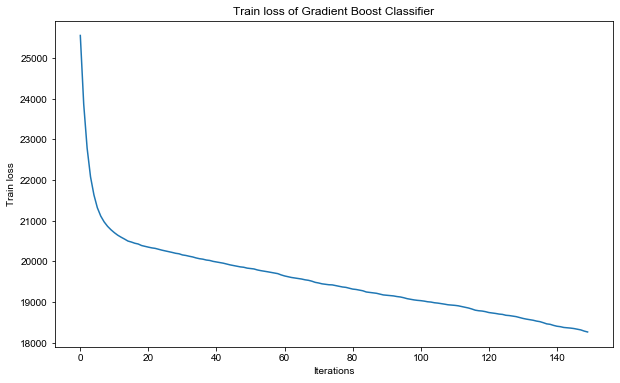

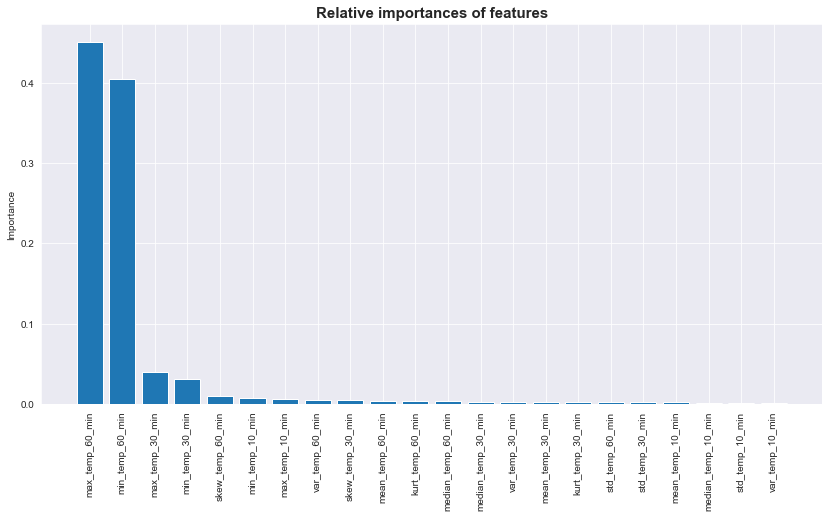

In [2]:
## Load trained model
filename = 'Temp_GB_PdM_model.sav'
my_model = pickle.load(open(filename, 'rb'))
print("model loaded")


## make prediction(test)
test_result = pd.DataFrame(labeled_temp_feat.loc[labeled_temp_feat['date'] > first_test_date])
test_result['predicted_state'] = my_model.predict(test_X)
print ("test_result", test_result)
test_results.append(test_result)
models.append(my_model)

##save prediction result to csv file
export_test_csv = test_results[0].to_csv('test_result_temp_GB.csv')
# test_results = pd.read_csv('test_result_GBC.csv')
train_loss = my_model.train_score_
# print ("train_loss_", train_loss)
# print ("train loss dtype", train_loss.dtype)


## plot training loss curve
plt.figure(figsize=(10,6))
plt.plot(train_loss)
plt.title('Train loss of Gradient Boost Classifier')
plt.ylabel('Train loss')
plt.xlabel('Iterations')


sns.set_style("darkgrid")
plt.figure(figsize=(14, 7))
labels, importances = zip(*sorted(zip(test_X.columns, models[0].feature_importances_), reverse=True, key=lambda x: x[1]))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')
plt.title("Relative importances of features", fontdict={'fontsize':15, 'fontweight':'bold'})
plt.savefig('barchart_importances.png', bbox_inches='tight')

In [3]:
### Evaluation

from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score


def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []

    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
    print(cm)

    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(['accuracy', 'precision', 'recall', 'F1'])

    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(['macro precision', 'macro recall', 'macro F1'])

    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis=1)
    cm_col_sums = cm.sum(axis=0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis=1)

    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0, 0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(['average accuracy',
                          'micro-averaged precision/recall/F1'])

    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist
    mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist
    mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(['majority class accuracy', 'majority class recall',
                          'majority class precision', 'majority class F1'])

    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(['expected accuracy', 'kappa'])

    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(['random guess accuracy', 'random guess precision',
                          'random guess recall', 'random guess F1'])

    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist ** 2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(['random weighted guess accuracy',
                          'random weighted guess precision',
                          'random weighted guess recall',
                          'random weighted guess F1'])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels

    return output_df


evaluation_results = []
for i, test_result in enumerate(test_results):
    print('\nSplit %d:' % (i + 1))
    evaluation_result = Evaluate(actual=test_result['label'],
                                 predicted=test_result['predicted_state'],
                                 labels=['none', 'abnormal(cold)', 'abnormal(hot)'])
    evaluation_results.append(evaluation_result)
print (evaluation_results[0])  # show full results for first split only


Split 1:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[4854   36   38]
 [  77   98    5]
 [ 110    2  158]]
                                        none  abnormal(cold)  abnormal(hot)
accuracy                            0.950167        0.950167       0.950167
precision                           0.962904        0.720588       0.786070
recall                              0.984984        0.544444       0.585185
F1                                  0.973819        0.620253       0.670913
macro precision                     0.823187        0.823187       0.823187
macro recall                        0.704871        0.704871       0.704871
macro F1                            0.754995        0.754995       0.754995
average accuracy                    0.966778        0.966778       0.966778
micro-averaged precision/recall/F1  0.950167        0.950167       0.950167
majority class accuracy             0.916326        0.000000       0.000000
majority 

<Figure size 864x432 with 0 Axes>

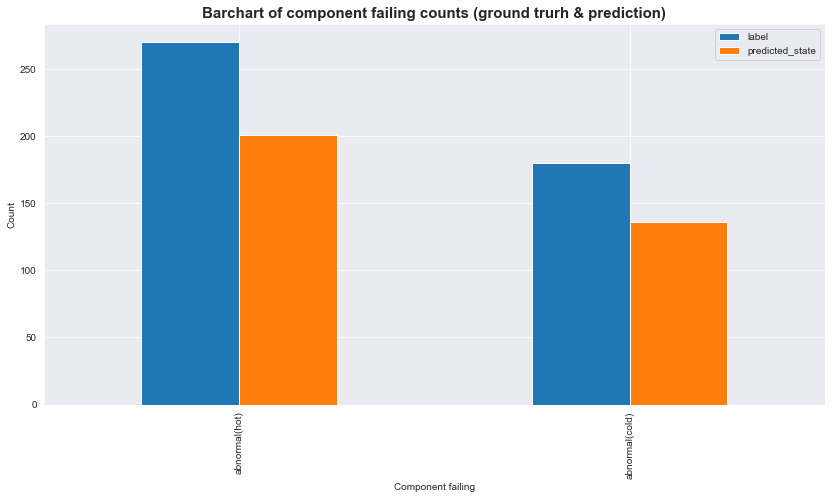

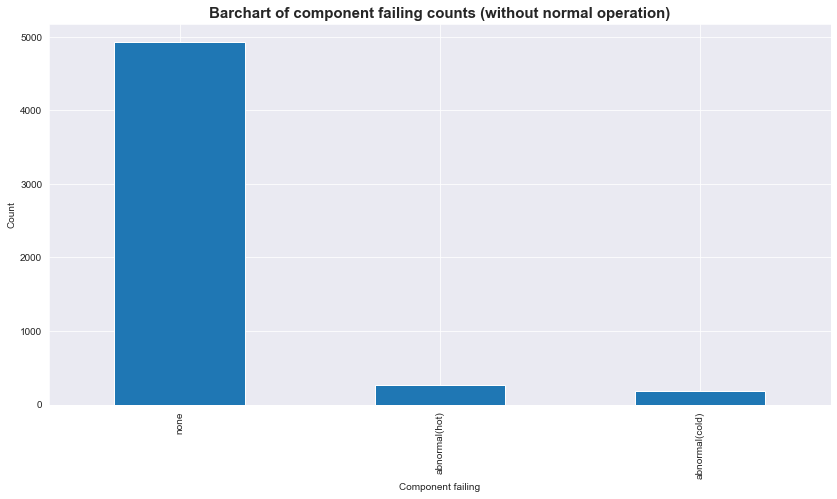

In [4]:

## Draw the barchart of component failing(ground trurh & prediction)
plt.figure(figsize=(12, 6))
counts_failures = test_result['label'].value_counts().drop('none')
counts_pd_failures = test_result['predicted_state'].value_counts().drop('none')
counts = pd.concat([counts_failures,counts_pd_failures],axis=1)
# print ("counts", counts )
sns.set_style("darkgrid")
ax = counts.plot(kind='bar', legend='true')
fig = plt.gcf()
fig.set_size_inches(14,7)
plt.xlabel('Component failing')
plt.ylabel('Count')
plt.title("Barchart of component failing counts (ground trurh & prediction)" , fontdict = {'fontsize':15, 'fontweight':'bold'})
plt.savefig('barchart_truth.png', bbox_inches='tight')


## Draw the barchart of component failing(ground trurh)
sns.set_style("darkgrid")
plt.figure(figsize=(14, 7))
test_result['label'].value_counts().plot(kind='bar')
plt.xlabel('Component failing')
plt.ylabel('Count')
plt.title("Barchart of component failing counts (without normal operation)" , fontdict = {'fontsize':15, 'fontweight':'bold'})
plt.savefig('barchart_truth(w none).png', bbox_inches='tight')
